In [49]:
import pandas as pd
import numpy as np
import os
import re

# Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

%matplotlib inline

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

# Reading Dataset

In [2]:
# consumer dataset
consumer = spark.read.option("delimiter", "|").csv('tbl_consumer.csv', header = True)
consumer_postcode = consumer.drop("name","address")
consumer_postcode

state,postcode,gender,consumer_id
WA,6935,Female,1195503
NSW,2782,Female,179208
NT,862,Female,1194530
NSW,2780,Female,154128
WA,6355,Female,712975
NSW,2033,Female,407340
QLD,4606,Female,511685
WA,6056,Male,448088
NSW,2482,Female,650435
VIC,3220,Female,1058499


In [3]:
consumer_postcode = consumer_postcode.toPandas()
consumer_postcode["postcode"] = pd.to_numeric(consumer_postcode["postcode"])
consumer_postcode

,state,postcode,gender,consumer_id
0,WA,6935,Female,1195503
1,NSW,2782,Female,179208
2,NT,862,Female,1194530
3,NSW,2780,Female,154128
4,WA,6355,Female,712975
...,...,...,...,...
499994,QLD,4400,Female,1385608
499995,VIC,3097,Undisclosed,1466964
499996,NSW,2756,Undisclosed,1253484
499997,VIC,3989,Female,175005


In [4]:
# SA2 dataset
import pandas as pd
import io
import requests
url="https://www.matthewproctor.com/Content/postcodes/australian_postcodes.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))
sa2_code = df[['postcode','SA2_MAINCODE_2016']]
sa2_code.rename(columns = {'SA2_MAINCODE_2016':'SA2_code'},inplace=True)
sa2_code = sa2_code.drop_duplicates()

sa2_code

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,postcode,SA2_code
0,200,801051049.0
2,800,701011002.0
4,801,701011002.0
5,804,701011007.0
6,810,701021010.0
...,...,...
18437,9013,305011105.0
18438,9015,305011105.0
18439,9464,302031038.0
18440,9726,309101268.0


In [5]:
# Income dataset
income = pd.read_csv("./SA2/AUS/2021Census_G02_AUST_SA2.csv")
income = income[['SA2_CODE_2021','Median_age_persons','Median_tot_prsnl_inc_weekly']]
income.rename(columns = {'SA2_CODE_2021':'SA2_code'},inplace=True)
income

,SA2_code,Median_age_persons,Median_tot_prsnl_inc_weekly
0,101021007,51,760
1,101021008,38,975
2,101021009,37,996
3,101021010,36,1104
4,101021012,37,1357
...,...,...,...
2467,901021002,40,741
2468,901031003,38,585
2469,901041004,50,736
2470,997979799,0,0


# join

In [6]:
merge1 = pd.merge(consumer_postcode, sa2_code, how='left', on = 'postcode')
merge2 = pd.merge(merge1,income, how = 'left',on='SA2_code')
merge2

,state,postcode,gender,consumer_id,SA2_code,Median_age_persons,Median_tot_prsnl_inc_weekly
0,WA,6935,Female,1195503,504031066.0,40.0,749.0
1,NSW,2782,Female,179208,124011455.0,50.0,740.0
2,NT,862,Female,1194530,702021055.0,26.0,416.0
3,NT,862,Female,1194530,702051066.0,28.0,276.0
4,NT,862,Female,1194530,702021056.0,33.0,671.0
...,...,...,...,...,...,...,...
882478,NSW,2756,Undisclosed,1253484,124041466.0,39.0,790.0
882479,NSW,2756,Undisclosed,1253484,115031300.0,40.0,907.0
882480,NSW,2756,Undisclosed,1253484,115041301.0,39.0,920.0
882481,VIC,3989,Female,175005,NaN,NaN,NaN


I merged consumer dataset and sa2 dataset by postcode, and named merge1.

Then I merged income dataset with merge1 by sa2_code, then named merge2.

In [7]:
user_detail = spark.read.parquet("consumer_user_details.parquet")
user_detail

user_id,consumer_id
1,1195503
2,179208
3,1194530
4,154128
5,712975
6,407340
7,511685
8,448088
9,650435
10,1058499


In [8]:
#!pip install pandasql

In [8]:
from pandasql import sqldf

query = """
SELECT consumer_id,
avg(Median_age_persons) as mean_age,
avg(Median_tot_prsnl_inc_weekly) as mean_tot_prsnl_inc_weekly

from merge2
group by consumer_id
order by consumer_id

"""


df1 = sqldf(query)

df1

ModuleNotFoundError: No module named 'pandasql'

In [10]:
df1.to_csv("../curated/weekly_income.csv", index = None)
df1 = spark.read.csv("../curated/weekly_income.csv",header = True)
df1

consumer_id,mean_age,mean_tot_prsnl_inc_weekly
10,42.0,770.0
100,null,null
1000002,55.0,562.0
1000003,40.0,780.0
1000006,45.0,830.0
1000008,47.0,768.0
1000023,39.0,871.0
1000024,null,null
1000027,39.0,931.0
1000030,50.0,684.0


df1 table shows mean age and mean weekly income of consumers(consumer_id).

In [11]:
df1.createOrReplaceTempView("df1") 
user_detail.createOrReplaceTempView("user_detail_tmp")

user_detail_income = spark.sql(
    """
    Select a.*, b.user_id

    from df1 as a right join user_detail_tmp as b
    on  a.consumer_id = b.consumer_id 
    """)

user_detail_income

consumer_id,mean_age,mean_tot_prsnl_inc_weekly,user_id
1195503,40.0,749.0,1
179208,50.0,740.0,2
1194530,29.0,454.3333333333333,3
154128,50.0,687.0,4
712975,44.0,897.0,5
407340,32.0,946.0,6
511685,47.0,490.0,7
448088,39.333333333333336,803.0,8
650435,46.0,654.0,9
1058499,40.0,922.0,10


Then, I joined with user_detail dataset to get user_id, and named user_detail_income.

In [10]:
path = "transactions_20210228_20210827_snapshot/"
# list_files = os.listdir(path)
# list_files = list_files[1:(len(list_files)-1)]

# # import modules
# from pyspark.sql import SparkSession
# import functools
 
# # explicit function
# def unionAll(dfs):
#     return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

# # read files
# file_name = os.listdir(path+ list_files[0])[1]
# transaction = spark.read.parquet(path+ list_files[0] +"/" + file_name)
# transaction = transaction.withColumn('order_datetime',lit(list_files[0][15:]))
# for i in list_files[1:]:
#     file_name = os.listdir(path + i)[1]
#     tmp = spark.read.parquet(path+ i +"/" + file_name)
#     tmp = tmp.withColumn('order_datetime',lit(i[15:]))
#     transaction = unionAll([transaction, tmp] )

transaction = spark.read.parquet(path,header = True)

# Join transaction data with customer data
customer_transaction = (transaction.join(user_detail, transaction.user_id == user_detail.user_id)
                                   .drop(user_detail.user_id))

customer_transaction = (customer_transaction.join(consumer, customer_transaction.consumer_id == consumer.consumer_id)
                                            .drop(consumer.consumer_id)
                                            .select(transaction['*'], consumer.postcode, consumer.state, consumer.gender))
#make 'month' column extracting from 'order_datetime'
customer_transaction = customer_transaction.select(col("*"),col("order_datetime"),
          month(col("order_datetime")).alias('month')
                           )
customer_transaction

user_id,merchant_abn,dollar_value,order_id,order_datetime,postcode,state,gender,order_datetime,month
5630,60956456424,145.26081329000152,1e14adeb-8e13-44f...,2021-08-21,841,NT,Undisclosed,2021-08-21,8
5630,48534649627,120.25889985200416,08476339-f383-4ab...,2021-08-15,841,NT,Undisclosed,2021-08-15,8
5630,60956456424,135.5412540082104,aacfd47a-438b-47f...,2021-08-15,841,NT,Undisclosed,2021-08-15,8
5630,89932674734,95.37693966478514,6d5790c9-0eef-453...,2021-08-16,841,NT,Undisclosed,2021-08-16,8
5630,14089706307,440.12097711482835,43d1361a-1101-41a...,2021-08-16,841,NT,Undisclosed,2021-08-16,8
5630,33604812025,268.4088838875397,4d8b6deb-a4d7-412...,2021-08-13,841,NT,Undisclosed,2021-08-13,8
5630,81219314324,48.20692954489542,6454fbb0-7cbd-4db...,2021-07-23,841,NT,Undisclosed,2021-07-23,7
5630,94472466107,141.26779955902157,d85af812-4f34-46b...,2021-05-21,841,NT,Undisclosed,2021-05-21,5
5630,15903176024,44.68660714566651,4bae0c2f-0d25-4f6...,2021-05-21,841,NT,Undisclosed,2021-05-21,5
5630,73527950332,654.6729455135422,44f25667-6711-4c5...,2021-07-30,841,NT,Undisclosed,2021-07-30,7


I brought this code from ETL-yjc.ipynb.

It reads transaction folder, join with customer and made 'month' column extracting from 'order_datetime'. This dataset is customer_transaction.

# Making VIP data

### For each customers(user_id), which merchants and how many times did they visit?

In [11]:
customer_transaction.createOrReplaceTempView("customer_transaction")


customer_transaction_count = spark.sql(
    """
    Select  user_id, merchant_abn,
    count(order_id) as count_order

    from customer_transaction
    group by user_id, merchant_abn 
    order by  count_order desc
    """)
customer_transaction_count

user_id,merchant_abn,count_order
5024,43186523025,12
15077,24852446429,12
18011,24852446429,12
1118,24852446429,11
9852,24852446429,11
13856,24852446429,11
8951,86578477987,11
8633,86578477987,11
21272,86578477987,11
1640,64203420245,11


This table shows which customer visited which merchants for how many times.

For example, user_id 5024 visited 43186523025 merchant for 12 times.

# What is the distribution of visited number of consumers(count_order)?

In [12]:
customer_transaction_count.createOrReplaceTempView("customer_transaction_count")


dist = spark.sql(
    """
    Select  count_order,
    count(count_order) as N 

    from customer_transaction_count
    group by count_order
    """)
dist

count_order,N
7,2723
6,7341
9,283
5,17885
1,2455398
10,78
3,89832
12,3
8,872
11,19


In [13]:
dist = dist.toPandas()
dist = dist.sort_values(by = 'count_order')
dist

,count_order,N
4,1,2455398
10,2,298654
6,3,89832
11,4,39496
3,5,17885
1,6,7341
0,7,2723
8,8,872
2,9,283
5,10,78


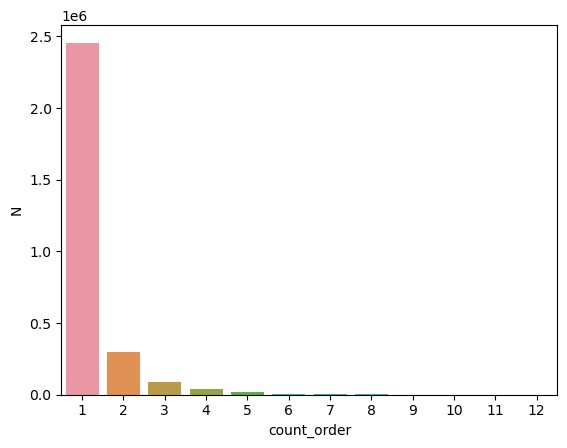

In [14]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x = 'count_order',
            y = 'N',
            data = dist)
 
# Show the plot
plt.show()

According to the bar plot, it shows that the distribution follows Poisson distribution.

Hence, the standard of VIPs will be set based on this distribution.

In [66]:
customer_trans_count.select(
    mean(col('count(order_id)')).alias('mean'),
    stddev(col('count(order_id)')).alias('std')
)

mean,std
1.2508707045015697,0.7097678950711641


In [67]:
# variance of total orders per cust on a merchant
0.7098**2

0.50381604

mean $\neq$ variance. So I dont think Poisson fits the data.

### Setting Returning Customers metrics

Test if there's any difference in grouping method using sql and built in function.

In [38]:
customer_trans_count = customer_transaction.groupby(['merchant_abn','user_id']).agg({'order_id':'count',
                                                                                     'dollar_value':'sum'})

In [19]:
customer_trans_count.groupby('count(order_id)').agg({'user_id':'count'})

count(order_id),count(user_id)
7,2723
6,7341
9,283
5,17885
1,2455398
10,78
3,89832
12,3
8,872
11,19


In [39]:
return_metric = customer_trans_count.groupby('merchant_abn').agg(
    count(when(col('count(order_id)')>2, True)).alias('returning_customer')
)



In [40]:
return_metric

merchant_abn,returning_customer
24406529929,0
15613631617,0
83412691377,11
38700038932,0
73256306726,0
35344855546,0
48214071373,0
96946925998,0
73841664453,0
19839532017,0


In [41]:
return_metric.where(col('returning_customer')>0).count()

574

Only 574/4359 (13.2%) of merchants have 1 or more returning customers.

### By each merchant, what is average number of visiting frequency per 1 customer and the value of standard deviation?

In [35]:
customer_transaction_count.createOrReplaceTempView("customer_transaction_count")


customer_transaction_count_mean = spark.sql(
    """
    Select  merchant_abn,
    avg(count_order) as mean_visited_user ,
    std(count_order) as std_visited_user 

    from customer_transaction_count
    group by merchant_abn 
    """)
customer_transaction_count_mean

merchant_abn,mean_visited_user,std_visited_user
83412691377,1.0780834072759538,0.28020806960531564
24406529929,1.0215475024485798,0.14527173640515173
38700038932,1.0318613750698715,0.1756800491057901
73841664453,1.0077220077220077,0.08770448939204492
73256306726,1.029126213592233,0.16822310100410454
35344855546,1.0078740157480315,0.08850182800306422
19839532017,1.0106382978723405,0.10286597386359325
15613631617,1.005859375,0.07639661003892982
29216160692,1.0239574090505768,0.1586833871813572
59128133246,1.0303217821782178,0.17509702338859554


Using 'customer_transaction_count' dataset, I figured out the mean and standard deviation of 'count_user_id' per 1 customer by each merchant.

### How to set the standard of VIPs?

In [36]:
#https://stats.stackexchange.com/questions/296255/is-the-proporation-of-outliers-detected-by-mean-2-5standard-deviation-for-poi -> 2.5인 이유

customer_transaction_count_mean.createOrReplaceTempView("customer_transaction_count_mean")\

join_data = spark.sql(
    """
    Select a.*, b.mean_visited_user, b.std_visited_user,
    b.mean_visited_user + 2.5* b.std_visited_user as vip_standard

    from customer_transaction_count as a left join customer_transaction_count_mean as b
    on  a.merchant_abn = b.merchant_abn 
    """)
join_data


user_id,merchant_abn,count_order,mean_visited_user,std_visited_user,vip_standard
21223,49891706470,11,2.843536198184501,1.5045697489880956,6.60496057065474
5024,43186523025,12,2.426085320539956,1.3264281797203297,5.74215576984078
1120,45629217853,11,2.640505638413969,1.4262816579485622,6.206209783285375
1782,45629217853,11,2.640505638413969,1.4262816579485622,6.206209783285375
8009,86578477987,11,3.060587461639632,1.6002360205596278,7.061177513038702
11998,86578477987,11,3.060587461639632,1.6002360205596278,7.061177513038702
8951,86578477987,11,3.060587461639632,1.6002360205596278,7.061177513038702
8633,86578477987,11,3.060587461639632,1.6002360205596278,7.061177513038702
21272,86578477987,11,3.060587461639632,1.6002360205596278,7.061177513038702
9928,64203420245,11,2.958622518898369,1.538645566811654,6.805236435927505


### Is this customer can be VIP of the merchant?

In [38]:
vip = join_data.withColumn("VIP", \
   when((join_data.count_order > join_data.vip_standard), lit(1)) \
     .otherwise(lit(0)) \
  )
vip

user_id,merchant_abn,count_order,mean_visited_user,std_visited_user,vip_standard,VIP
3539,73256306726,1,1.029126213592233,0.16822310100410454,1.4496839661024943,0
14703,83412691377,1,1.0780834072759538,0.28020806960531564,1.778603581289243,0
17474,19839532017,1,1.0106382978723405,0.10286597386359325,1.2678032325313238,0
4014,73841664453,1,1.0077220077220077,0.08770448939204492,1.22698323120212,0
20627,24406529929,1,1.0215475024485798,0.14527173640515173,1.384726843461459,0
21162,34440496342,1,1.0,0.0,1.0,0
18306,24406529929,1,1.0215475024485798,0.14527173640515173,1.384726843461459,0
15297,24406529929,1,1.0215475024485798,0.14527173640515173,1.384726843461459,0
8586,19839532017,1,1.0106382978723405,0.10286597386359325,1.2678032325313238,0
6238,73256306726,1,1.029126213592233,0.16822310100410454,1.4496839661024943,0


Using join_data, if 'count_user_id'(how many times one visited) > vip_standard(standard to become possible VIP), write 1.

Otherwise, 0.

### How many vips are in each merchant?
### What is the percentage of the vips in each merchant?

In [39]:
vip.createOrReplaceTempView("vip")


vip_count = spark.sql(
    """
    Select   merchant_abn,
    sum(VIP) as sum_vip,
    avg(VIP) * 100 as percentage_vip 

    from vip
    group by merchant_abn 
    order by  sum_vip desc, percentage_vip desc
    """)
vip_count

merchant_abn,sum_vip,percentage_vip
20985347699,723,6.11985779583545
89726005175,708,3.265833294893676
72472909171,597,3.734751329371286
43186523025,574,2.6997789379615256
37459245212,573,10.758542996620353
86662713230,567,11.185638192937462
14430838529,555,11.0381861575179
79417999332,552,3.5298631538559917
39649557865,550,10.880316518298715
64203420245,546,2.4136863975951552


In [40]:
vip_count = vip_count.toPandas()

In [41]:
vip_count.to_csv("../curated/vip_count.csv")

Using vip dataset, I showed the number of vip customers and the percentage of vip customers compared to all the number of visited customers in each merchant.

### Alternative VIP metric - Find number of customers who spent more than x amount for each merchant

In [45]:
tot_spend_per_cust = customer_trans_count.select('sum(dollar_value)').toPandas()

In [52]:
tot_spend_per_cust['log(dollar_value)'] = np.log(tot_spend_per_cust['sum(dollar_value)'])

In [55]:
tot_spend_per_cust['sum(dollar_value)'].mean()

207.9946248641335

In [59]:
(tot_spend_per_cust['sum(dollar_value)'].std())**2

337413.9699932315

Mean $\neq$ variance so Poisson definitely does not fit here.

(array([2.911333e+06, 9.390000e+02, 2.330000e+02, 5.700000e+01,
        1.500000e+01, 4.000000e+00, 1.000000e+00, 1.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([9.75665810e-08, 1.05193886e+04, 2.10387772e+04, 3.15581657e+04,
        4.20775543e+04, 5.25969429e+04, 6.31163315e+04, 7.36357201e+04,
        8.41551086e+04, 9.46744972e+04, 1.05193886e+05]),
 <BarContainer object of 10 artists>)

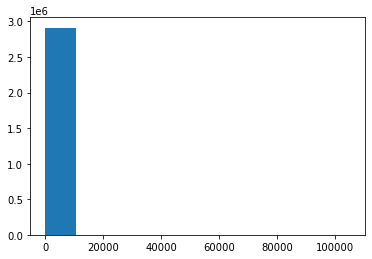

In [68]:
plt.hist(tot_spend_per_cust['sum(dollar_value)'])

way too skewed. Need to check by sorting descending order.

In [69]:
tot_spend_per_cust.sort_values('sum(dollar_value)', ascending=False)

,sum(dollar_value),log(dollar_value)
374967,1.051939e+05,11.563560
227616,7.713421e+04,11.253302
2287703,6.566003e+04,11.092246
1966991,5.922393e+04,10.989081
2383527,5.817653e+04,10.971237
...,...,...
226738,2.350175e-04,-8.355850
117845,1.731625e-04,-8.661280
133142,1.153147e-04,-9.067846
426619,5.364306e-05,-9.833159


<div class="alert alert-block alert-danger">Turned out the dataset used is is uncleaned ones, so the analysis might not be correct. Moving analysis to a new notebook. </div>

# In Progress - merge with income dataset

In [42]:
user_detail_income.createOrReplaceTempView("user_detail_income") 
customer_transaction_count.createOrReplaceTempView("customer_transaction_count")

user_detail_income_merchant = spark.sql(
    """
    Select a.*, b.merchant_abn

    from user_detail_income as a right join customer_transaction_count as b
    on  a.user_id = b.user_id 
    """)

user_detail_income_merchant

consumer_id,mean_age,mean_tot_prsnl_inc_weekly,user_id,merchant_abn
511685,47.0,490.0,7,90543168331
738803,49.0,718.0,22,89726005175
1421465,51.0,572.0,26,94493496784
1036773,48.75,636.25,1640,64203420245
567823,null,null,1782,45629217853
846132,41.0,775.0,9852,24852446429
355159,33.0,862.0,21223,49891706470
717325,36.5,630.25,21272,86578477987
1242900,43.0,672.5,5517,30122382323
1242900,43.0,672.5,5517,31940875883


In [43]:
user_detail_income_merchant.createOrReplaceTempView("user_detail_income_merchant")


user_detail_income_merchant_mean = spark.sql(
    """
    Select  merchant_abn,
    avg(mean_tot_prsnl_inc_weekly) as mean_customer_inc_weekly ,
    std(mean_tot_prsnl_inc_weekly) as std_customer_inc_weekly 

    from user_detail_income_merchant
    group by merchant_abn 
    """)
user_detail_income_merchant_mean

merchant_abn,mean_customer_inc_weekly,std_customer_inc_weekly
38700038932,796.6748411331818,227.68765173631013
83412691377,861.9971800208293,2389.3626201637076
73256306726,810.0606773561418,219.64286554809624
24406529929,799.099053109456,227.24310631029138
35344855546,794.3024451792552,213.5763669300188
19839532017,1380.199381412725,7184.5666090689765
73841664453,784.7087688294201,221.6568946570267
15613631617,805.9568355836848,214.10612016484242
60654402457,2904.4457364341088,13989.429224668596
92202115241,784.6686274509805,187.51042654577603


In [45]:
user_detail_income_merchant_mean.createOrReplaceTempView("user_detail_income_merchant_mean")

join_data_income = spark.sql(
    """
    Select a.*, b.mean_customer_inc_weekly, b.std_customer_inc_weekly,
    b.mean_customer_inc_weekly + 2.5* b.std_customer_inc_weekly as vip_standard_inc

    from user_detail_income_merchant as a left join user_detail_income_merchant_mean as b
    on a.merchant_abn = b.merchant_abn 
    """)
join_data_income

consumer_id,mean_age,mean_tot_prsnl_inc_weekly,user_id,merchant_abn,mean_customer_inc_weekly,std_customer_inc_weekly,vip_standard_inc
355159,33.0,862.0,21223,49891706470,825.1245865999408,1611.9196138705338,4854.923621276275
738803,49.0,718.0,22,89726005175,821.1339349261254,1496.9190331121415,4563.431517706479
567823,null,null,1782,45629217853,821.010150238438,1486.913477316326,4538.293843529253
717325,36.5,630.25,21272,86578477987,824.9359953950548,1597.3929321966116,4818.418325886583
511685,47.0,490.0,7,90543168331,822.2811525858966,1604.0780604388299,4832.476303682972
1036773,48.75,636.25,1640,64203420245,820.2745744128619,1466.9804502931156,4487.725700145651
1421465,51.0,572.0,26,94493496784,811.7238604854531,1124.0147502802868,3621.76073618617
846132,41.0,775.0,9852,24852446429,820.7515093668708,1455.9374735925157,4460.59519334816
782012,36.0,940.0,13856,24852446429,820.7515093668708,1455.9374735925157,4460.59519334816
1470379,35.0,845.5,18011,24852446429,820.7515093668708,1455.9374735925157,4460.59519334816
